In [1]:
import numpy as np

from mpi4py import MPI
from petsc4py import PETSc

import dolfinx
import ufl
from basix.ufl import blocked_element, element, enriched_element, mixed_element
from dolfinx.fem import Function, functionspace, dirichletbc, Expression, locate_dofs_topological, Constant
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary, meshtags
from ufl import grad, inner, split
from dolfinx import plot, default_scalar_type
from dolfinx.nls.petsc import NewtonSolver
from tqdm import tqdm
import pyvista

# Simulation setup

In [2]:
nex = int(6)
ney = int(30)

PSRI_control = False
plot_control = False

ele_dict = {0 : "tri_P1",
            1 : "tri_P2",
            2 : "tri_P2B3",
            3 : "qua_P1",
            4 : "qua_P2"}

ele_index = 4
ele_type = ele_dict[ele_index]


if ele_type == "tri_P2B3":
    cell_type = CellType.triangle
    
elif ele_type == "tri_P2":
    cell_type = CellType.triangle

elif ele_type == "tri_P1":
    cell_type = CellType.triangle
    
elif ele_type == "qua_P2":
    cell_type = CellType.quadrilateral
    
elif ele_type == "qua_P1":
    cell_type = CellType.quadrilateral

In [3]:
from pathlib import Path

if not PSRI_control:
    results_folder = Path(f"results/nonlinear_Naghdi/non_PSRI/slit-annular-plate/{nex}_{ney}_{ele_type}")
else:
    results_folder = Path(f"results/nonlinear_Naghdi/slit-annular-plate/{nex}_{ney}_{ele_type}")

results_folder.mkdir(exist_ok=True, parents=True)

if plot_control:
    pyvista.start_xvfb()

# Mesh

In [4]:
R0 = 6.0
dR = 4.0
Ra = R0 + dR/2

mesh = create_rectangle(MPI.COMM_WORLD, np.array([[0.0, 0.0], [dR, Ra*2*np.pi]]), 
                        [nex, ney], cell_type)
tdim = mesh.topology.dim
fdim = tdim - 1

cell = mesh.basix_cell()
P1 = element("Lagrange", cell, degree=1)
P2 = element("Lagrange", cell, degree=2)
B3 = element("Bubble", cell, degree=3)

## plot mesh

In [5]:
topology, cell_types, geometry = plot.vtk_mesh(mesh, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter(off_screen = True)
plotter.add_mesh(grid, show_edges=True)
#plotter.show_grid()
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(results_folder/f"mesh_rank{mesh.comm.rank}.png")

plotter.close()

Widget(value='<iframe src="http://localhost:39753/index.html?ui=P_0x7fb43effad20_0&reconnect=auto" class="pyvi…

# Material

In [5]:
E, nu = Constant(mesh, default_scalar_type(21.0E6)), Constant(mesh, default_scalar_type(0.0))
mu = E/(2.0*(1.0 + nu))
lmbda = 2.0*mu*nu/(1.0 - 2.0*nu)
t = Constant(mesh, default_scalar_type(3E-2))

# Initial shape

In [6]:
x = ufl.SpatialCoordinate(mesh)
phi0_ufl = ufl.as_vector([(R0 + x[0])*ufl.cos(x[1] / Ra),
                          (R0 + x[0])*ufl.sin(x[1] / Ra),
                          0])

def unit_normal(phi):
    n = ufl.cross(phi.dx(0), phi.dx(1))
    return n/ufl.sqrt(inner(n, n))

n0_ufl = unit_normal(phi0_ufl)

def tangent_1(n):
    e2 = ufl.as_vector([0, 1, 0])
    t1 = ufl.cross(e2, n)
    t1 = t1/ufl.sqrt(inner(t1, t1))
    return t1

def tangent_2(n, t1):
    t2 = ufl.cross(n, t1)
    t2 = t2/ufl.sqrt(inner(t2, t2))
    return t2

# the analytical expression of t1 and t2
t1_ufl = tangent_1(n0_ufl)
t2_ufl = tangent_2(n0_ufl, t1_ufl)

# the analytical expression of R0
def rotation_matrix(t1, t2, n):
    R = ufl.as_matrix([[t1[0], t2[0], n[0]], 
                       [t1[1], t2[1], n[1]], 
                       [t1[2], t2[2], n[2]]])
    return R

R0_ufl = rotation_matrix(t1_ufl, t2_ufl, n0_ufl)

# Update the director with two successive elementary rotations
def director(R0, theta):
    Lm3 = ufl.as_vector([ufl.sin(theta[1])*ufl.cos(theta[0]), -ufl.sin(theta[0]), ufl.cos(theta[1])*ufl.cos(theta[0])])
    d = ufl.dot(R0, Lm3)
    return d

## plot initial shape

In [8]:
# create a FEM interpolation of n0 and phi0
P1_d3_FS = functionspace(mesh, element("Lagrange", cell, degree = 1, shape = (3,)))

n0_P1_expr = Expression(n0_ufl, P1_d3_FS.element.interpolation_points())
n0_P1_func = Function(P1_d3_FS)
n0_P1_func.interpolate(n0_P1_expr)

phi0_P1_expr = Expression(phi0_ufl, P1_d3_FS.element.interpolation_points())
phi0_P1_func = Function(P1_d3_FS)
phi0_P1_func.interpolate(phi0_P1_expr)

topology, cell_types, geometry = plot.vtk_mesh(P1_d3_FS)

geometry_phi0_P1 = phi0_P1_func.x.array.reshape((geometry.shape[0], len(phi0_P1_func)))
geometry_n0_P1 = n0_P1_func.x.array.reshape((geometry.shape[0], len(n0_P1_func)))

grid_phi0_P1 = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi0_P1)
grid_phi0_P1["n0"] = geometry_n0_P1
glyphs = grid_phi0_P1.glyph(orient="n0", factor=1)


plotter = pyvista.Plotter(off_screen = True)
plotter.add_mesh(grid_phi0_P1, style="wireframe", color="k")
plotter.add_mesh(glyphs,  show_scalar_bar=True, scalar_bar_args={"vertical": True})
plotter.show_grid()
plotter.enable_parallel_projection()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(results_folder/f"initial_shape_rank{mesh.comm.rank}.png")
    
plotter.close()

Widget(value='<iframe src="http://localhost:63323/index.html?ui=P_0x310e46cf0_0&reconnect=auto" class="pyvista…

# Shell element

In [7]:
if ele_type == "tri_P2B3":
    P2B3 = enriched_element([P2, B3])
    naghdi_shell_element = mixed_element(
        [blocked_element(P2B3, shape=(3,)), blocked_element(P2, shape=(2,))]
    )
elif ele_type == "tri_P2":
    naghdi_shell_element = mixed_element(
        [blocked_element(P2, shape=(3,)), blocked_element(P2, shape=(2,))]
        )

elif ele_type == "tri_P1":
    naghdi_shell_element = mixed_element(
        [blocked_element(P1, shape=(3,)), blocked_element(P1, shape=(2,))]
    )
    
elif ele_type == "qua_P2":
    naghdi_shell_element = mixed_element(
        [blocked_element(P2, shape=(3,)), blocked_element(P2, shape=(2,))]
    )
elif ele_type == "qua_P1":
    naghdi_shell_element = mixed_element(
        [blocked_element(P1, shape=(3,)), blocked_element(P1, shape=(2,))]
    )
    
naghdi_shell_FS = functionspace(mesh, naghdi_shell_element)

q_func = Function(naghdi_shell_FS) # current configuration
q_trial = ufl.TrialFunction(naghdi_shell_FS)
q_test = ufl.TestFunction(naghdi_shell_FS)

u_func, theta_func = split(q_func) # current displacement and rotation

# Shell model

In [8]:
# current deformation gradient 
F = grad(u_func) + grad(phi0_ufl) 

# current director
d = director(R0_ufl, theta_func)

# initial metric and curvature tensor a0 and b0
a0_ufl = grad(phi0_ufl).T * grad(phi0_ufl)
b0_ufl = -0.5*( grad(phi0_ufl).T * grad(n0_ufl) + grad(n0_ufl).T * grad(phi0_ufl))

def epsilon(F):
    """Membrane strain"""
    return 0.5 * (F.T * F - a0_ufl)


def kappa(F, d):
    """Bending strain"""
    return -0.5 * (F.T * grad(d) + grad(d).T * F) - b0_ufl


def gamma(F, d):
    """Transverse shear strain"""
    return F.T * d

a0_contra_ufl = ufl.inv(a0_ufl)
j0_ufl = ufl.det(a0_ufl)

i,j,l,m = ufl.indices(4)  # noqa: E741
A_contra_ufl = ufl.as_tensor( ( ((2.0*lmbda*mu) / (lmbda + 2.0*mu)) * a0_contra_ufl[i,j]*a0_contra_ufl[l,m]
                + 1.0*mu* (a0_contra_ufl[i,l]*a0_contra_ufl[j,m] + a0_contra_ufl[i,m]*a0_contra_ufl[j,l]) )
                ,[i,j,l,m])

N = ufl.as_tensor(t * A_contra_ufl[i,j,l,m] * epsilon(F)[l,m], [i,j])

M = ufl.as_tensor( (t**3 / 12.0) * A_contra_ufl[i,j,l,m]*kappa(F, d)[l,m], [i,j])

T = ufl.as_tensor( (t * mu *5.0 / 6.0) * a0_contra_ufl[i, j] * gamma(F, d)[j], [i])

psi_m = 0.5*inner(N, epsilon(F))

psi_b = 0.5*inner(M, kappa(F, d))

psi_s = 0.5*inner(T, gamma(F, d))

# External work

In [9]:
def free_end(x):
    return np.isclose(x[1], 0.0)


def fixed_end(x):
    return np.isclose(x[1], Ra*2*np.pi)

free_facets = locate_entities_boundary(mesh, fdim, free_end)
fixed_facets = locate_entities_boundary(mesh, fdim, fixed_end)

# left facets are marked with tag 1, right facets are marked with tag 2
marked_facets = np.hstack([free_facets, fixed_facets])
marked_values = np.hstack([np.full_like(free_facets, 2), np.full_like(fixed_facets, 1)])
sorted_facets = np.argsort(marked_facets)
facet_tag = meshtags(mesh, fdim, marked_facets[sorted_facets], marked_values[sorted_facets])

P_right = Constant(mesh, default_scalar_type(0.0))

ds = ufl.Measure("ds", domain=mesh, subdomain_data=facet_tag, metadata={"quadrature_degree": 2})

W_ext = P_right * u_func[2] * ds(2)

# Potential energy with PSRI

In [10]:
if ele_type == "qua_P1":
    dx_f = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 3})
    if PSRI_control:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 1})
    else:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 3})
        
elif ele_type == "tri_P1":
    dx_f = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})
    dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 1})
    
else:
    dx_f = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 4})
    if PSRI_control:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})
    else:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 4})
        
# Calculate the factor alpha as a function of the mesh size h
h = ufl.CellDiameter(mesh)
alpha_FS = functionspace(mesh, element("DG", cell, 0))
alpha_expr = Expression(t**2 / h**2, alpha_FS.element.interpolation_points())
alpha = Function(alpha_FS)
alpha.interpolate(alpha_expr)

# Full integration part of the total elastic energy
Pi_PSRI = psi_b * ufl.sqrt(j0_ufl) * dx_f 
Pi_PSRI += alpha * psi_m * ufl.sqrt(j0_ufl) * dx_f
Pi_PSRI += alpha * psi_s * ufl.sqrt(j0_ufl) * dx_f

# Reduced integration part of the total elastic energy
Pi_PSRI += (1.0 - alpha) * psi_m * ufl.sqrt(j0_ufl) * dx_r
Pi_PSRI += (1.0 - alpha) * psi_s * ufl.sqrt(j0_ufl) * dx_r

# external work part
Pi_PSRI -= W_ext

Residual = ufl.derivative(Pi_PSRI, q_func, q_test)
Jacobian = ufl.derivative(Residual, q_func, q_trial)

# clamped boundary condtions

In [11]:
u_FS, _ = naghdi_shell_FS.sub(0).collapse()
theta_FS, _ = naghdi_shell_FS.sub(1).collapse()

# u1, u2, u3 = 0 on the clamped boundary
u_clamped = Function(u_FS) # default value is 0
clamped_dofs_u = locate_dofs_topological((naghdi_shell_FS.sub(0), u_FS), fdim, facet_tag.find(1))
bc_clamped_u = dirichletbc(u_clamped, clamped_dofs_u, naghdi_shell_FS.sub(0))

# theta1, theta2 = 0 on the clamped boundary
theta_clamped = Function(theta_FS) # default value is 0
clamped_dofs_theta = locate_dofs_topological((naghdi_shell_FS.sub(1), theta_FS), fdim, facet_tag.find(1))
bc_clamped_theta = dirichletbc(theta_clamped, clamped_dofs_theta, naghdi_shell_FS.sub(1))

bcs = [bc_clamped_u, bc_clamped_theta]

# bb tree

In [12]:
bb_tree = dolfinx.geometry.bb_tree(mesh, 2)
bb_point_A = np.array([[0.0, 0.0, 0.0]], dtype=np.float64)
bb_point_B = np.array([[dR, 0.0, 0.0]], dtype=np.float64)
# Find the leaf that the target point is in
bb_cell_candidates_A = dolfinx.geometry.compute_collisions_points(bb_tree, bb_point_A)
bb_cell_candidates_B = dolfinx.geometry.compute_collisions_points(bb_tree, bb_point_B)

# Find the cell from the leaf that contains the target point
bb_cells_A = dolfinx.geometry.compute_colliding_cells(
    mesh, bb_cell_candidates_A, bb_point_A)
bb_cells_B = dolfinx.geometry.compute_colliding_cells(
    mesh, bb_cell_candidates_B, bb_point_B)

# Newton solver

In [13]:
problem = NonlinearProblem(Residual, q_func, bcs, Jacobian)
solver = NewtonSolver(mesh.comm, problem)

# Set Newton solver options
solver.rtol = 1e-6
solver.atol = 1e-6
solver.max_it = 100
solver.convergence_criterion = "incremental"
solver.report = True

# Modify the linear solver in each Newton iteration
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"
opts[f"{option_prefix}pc_type"] = "lu"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

In [14]:
P_max = 0.8
nstep = 100
Ps = np.linspace(0.0, P_max, nstep)

if mesh.comm.rank == 0:
    WA_list = np.zeros(nstep)
    WB_list = np.zeros(nstep)
    
file_u = dolfinx.io.VTKFile(mesh.comm, results_folder/"u.pvd", "w")
file_theta = dolfinx.io.VTKFile(mesh.comm, results_folder/"theta.pvd", "w")
file_phi = dolfinx.io.VTKFile(mesh.comm, results_folder/"phi.pvd", "w")
 
q_func.x.array[:] = 0.0

#dolfinx.log.set_log_level(dolfinx.log.LogLevel.INFO)
#dolfinx.log.set_log_level(dolfinx.log.LogLevel.OFF)

for i, P_curr in enumerate(tqdm(Ps)):
    P_right.value = P_curr
    n, converged = solver.solve(q_func)
    assert (converged)
    q_func.x.scatter_forward()
    if mesh.comm.rank == 0:
        print(f"Load step {i:d}, Number of iterations: {n:d}, Load: {P_curr:.2f}({P_max:.2f})", flush=True)
    
    # write output
    if ele_type == "qua_P1" or ele_type == "tri_P1":
        phi_FS = functionspace(mesh, blocked_element(P1, shape=(3,)))
    else:
        phi_FS = functionspace(mesh, blocked_element(P2, shape=(3,)))
        
    if ele_type == "tri_P2B3":
        u_P2B3 = q_func.sub(0).collapse()
        u_sol = Function(phi_FS)
        u_sol.interpolate(u_P2B3)
    else:
        u_sol = q_func.sub(0).collapse()
    
    phi_expr = Expression(phi0_ufl + u_sol, phi_FS.element.interpolation_points())
    phi_sol = Function(phi_FS)
    phi_sol.interpolate(phi_expr)
    theta_sol = q_func.sub(1).collapse()

    file_u.write_function(u_sol, i)
    file_theta.write_function(theta_sol, i)
    file_phi.write_function(phi_sol, i)
    
    # calculate u3 at the point load
    WA_bb = None
    WB_bb = None
    u3_func = q_func.sub(0).sub(2).collapse()
    
    if len(bb_cells_A.array) > 0:
        WA_bb = u3_func.eval(bb_point_A, bb_cells_A.array[0])[0]
    WA_bb = mesh.comm.gather(WA_bb, root=0)
    
    if len(bb_cells_B.array) > 0:
        WB_bb = u3_func.eval(bb_point_B, bb_cells_B.array[0])[0]
    WB_bb = mesh.comm.gather(WB_bb, root=0)
    
    if mesh.comm.rank == 0:
        for WA in WA_bb:
            if WA is not None:
                WA_list[i] = WA
                break
            
        for WB in WB_bb:
            if WB is not None:
                WB_list[i] = WB
                break

# close the output files
file_u.close()
file_theta.close()
file_phi.close()

  0%|          | 0/100 [00:00<?, ?it/s]

Load step 0, Number of iterations: 2, Load: 0.00(0.80)


  1%|          | 1/100 [00:00<00:25,  3.95it/s]

Load step 1, Number of iterations: 9, Load: 0.01(0.80)


  2%|▏         | 2/100 [00:00<00:42,  2.32it/s]

Load step 2, Number of iterations: 9, Load: 0.02(0.80)


  3%|▎         | 3/100 [00:01<00:53,  1.83it/s]

Load step 3, Number of iterations: 9, Load: 0.02(0.80)


  4%|▍         | 4/100 [00:01<00:50,  1.89it/s]

Load step 4, Number of iterations: 9, Load: 0.03(0.80)


  5%|▌         | 5/100 [00:02<00:51,  1.84it/s]

Load step 5, Number of iterations: 9, Load: 0.04(0.80)


  6%|▌         | 6/100 [00:03<00:51,  1.82it/s]

Load step 6, Number of iterations: 9, Load: 0.05(0.80)


  7%|▋         | 7/100 [00:03<00:49,  1.88it/s]

Load step 7, Number of iterations: 8, Load: 0.06(0.80)


  8%|▊         | 8/100 [00:04<00:48,  1.90it/s]

Load step 8, Number of iterations: 8, Load: 0.06(0.80)


  9%|▉         | 9/100 [00:04<00:47,  1.91it/s]

Load step 9, Number of iterations: 7, Load: 0.07(0.80)


 10%|█         | 10/100 [00:05<00:45,  2.00it/s]

Load step 10, Number of iterations: 7, Load: 0.08(0.80)


 11%|█         | 11/100 [00:05<00:42,  2.08it/s]

Load step 11, Number of iterations: 7, Load: 0.09(0.80)


 12%|█▏        | 12/100 [00:05<00:41,  2.15it/s]

Load step 12, Number of iterations: 6, Load: 0.10(0.80)


 13%|█▎        | 13/100 [00:06<00:38,  2.29it/s]

Load step 13, Number of iterations: 6, Load: 0.11(0.80)


 14%|█▍        | 14/100 [00:06<00:36,  2.35it/s]

Load step 14, Number of iterations: 6, Load: 0.11(0.80)


 15%|█▌        | 15/100 [00:07<00:37,  2.25it/s]

Load step 15, Number of iterations: 6, Load: 0.12(0.80)


 16%|█▌        | 16/100 [00:07<00:34,  2.41it/s]

Load step 16, Number of iterations: 6, Load: 0.13(0.80)


 17%|█▋        | 17/100 [00:08<00:38,  2.18it/s]

Load step 17, Number of iterations: 6, Load: 0.14(0.80)


 18%|█▊        | 18/100 [00:08<00:35,  2.33it/s]

Load step 18, Number of iterations: 6, Load: 0.15(0.80)


 19%|█▉        | 19/100 [00:08<00:33,  2.43it/s]

Load step 19, Number of iterations: 6, Load: 0.15(0.80)


 20%|██        | 20/100 [00:09<00:31,  2.50it/s]

Load step 20, Number of iterations: 6, Load: 0.16(0.80)


 21%|██        | 21/100 [00:09<00:31,  2.51it/s]

Load step 21, Number of iterations: 6, Load: 0.17(0.80)


 22%|██▏       | 22/100 [00:10<00:31,  2.50it/s]

Load step 22, Number of iterations: 6, Load: 0.18(0.80)


 23%|██▎       | 23/100 [00:10<00:34,  2.21it/s]

Load step 23, Number of iterations: 5, Load: 0.19(0.80)


 24%|██▍       | 24/100 [00:10<00:31,  2.45it/s]

Load step 24, Number of iterations: 5, Load: 0.19(0.80)


 25%|██▌       | 25/100 [00:11<00:29,  2.54it/s]

Load step 25, Number of iterations: 5, Load: 0.20(0.80)


 26%|██▌       | 26/100 [00:11<00:28,  2.56it/s]

Load step 26, Number of iterations: 5, Load: 0.21(0.80)


 27%|██▋       | 27/100 [00:12<00:28,  2.56it/s]

Load step 27, Number of iterations: 5, Load: 0.22(0.80)


 28%|██▊       | 28/100 [00:12<00:26,  2.73it/s]

Load step 28, Number of iterations: 5, Load: 0.23(0.80)


 29%|██▉       | 29/100 [00:12<00:29,  2.37it/s]

Load step 29, Number of iterations: 5, Load: 0.23(0.80)


 30%|███       | 30/100 [00:13<00:26,  2.61it/s]

Load step 30, Number of iterations: 5, Load: 0.24(0.80)


 31%|███       | 31/100 [00:13<00:25,  2.73it/s]

Load step 31, Number of iterations: 5, Load: 0.25(0.80)


 32%|███▏      | 32/100 [00:13<00:24,  2.81it/s]

Load step 32, Number of iterations: 5, Load: 0.26(0.80)


 33%|███▎      | 33/100 [00:14<00:23,  2.89it/s]

Load step 33, Number of iterations: 5, Load: 0.27(0.80)


 34%|███▍      | 34/100 [00:14<00:22,  2.96it/s]

Load step 34, Number of iterations: 5, Load: 0.27(0.80)


 35%|███▌      | 35/100 [00:14<00:23,  2.80it/s]

Load step 35, Number of iterations: 5, Load: 0.28(0.80)


 36%|███▌      | 36/100 [00:15<00:22,  2.90it/s]

Load step 36, Number of iterations: 5, Load: 0.29(0.80)


 37%|███▋      | 37/100 [00:15<00:21,  2.88it/s]

Load step 37, Number of iterations: 5, Load: 0.30(0.80)


 38%|███▊      | 38/100 [00:15<00:21,  2.88it/s]

Load step 38, Number of iterations: 5, Load: 0.31(0.80)


 39%|███▉      | 39/100 [00:16<00:21,  2.90it/s]

Load step 39, Number of iterations: 5, Load: 0.32(0.80)


 40%|████      | 40/100 [00:16<00:20,  2.94it/s]

Load step 40, Number of iterations: 5, Load: 0.32(0.80)


 41%|████      | 41/100 [00:17<00:21,  2.72it/s]

Load step 41, Number of iterations: 5, Load: 0.33(0.80)


 42%|████▏     | 42/100 [00:17<00:21,  2.70it/s]

Load step 42, Number of iterations: 5, Load: 0.34(0.80)


 43%|████▎     | 43/100 [00:17<00:20,  2.74it/s]

Load step 43, Number of iterations: 5, Load: 0.35(0.80)


 44%|████▍     | 44/100 [00:18<00:20,  2.73it/s]

Load step 44, Number of iterations: 5, Load: 0.36(0.80)


 45%|████▌     | 45/100 [00:18<00:19,  2.78it/s]

Load step 45, Number of iterations: 5, Load: 0.36(0.80)


 46%|████▌     | 46/100 [00:18<00:20,  2.61it/s]

Load step 46, Number of iterations: 5, Load: 0.37(0.80)


 47%|████▋     | 47/100 [00:19<00:19,  2.71it/s]

Load step 47, Number of iterations: 4, Load: 0.38(0.80)


 48%|████▊     | 48/100 [00:19<00:18,  2.74it/s]

Load step 48, Number of iterations: 4, Load: 0.39(0.80)


 49%|████▉     | 49/100 [00:19<00:17,  2.98it/s]

Load step 49, Number of iterations: 4, Load: 0.40(0.80)


 50%|█████     | 50/100 [00:20<00:16,  3.00it/s]

Load step 50, Number of iterations: 4, Load: 0.40(0.80)


 51%|█████     | 51/100 [00:20<00:16,  3.03it/s]

Load step 51, Number of iterations: 4, Load: 0.41(0.80)


 52%|█████▏    | 52/100 [00:21<00:18,  2.61it/s]

Load step 52, Number of iterations: 4, Load: 0.42(0.80)


 53%|█████▎    | 53/100 [00:21<00:16,  2.85it/s]

Load step 53, Number of iterations: 4, Load: 0.43(0.80)


 54%|█████▍    | 54/100 [00:21<00:15,  2.97it/s]

Load step 54, Number of iterations: 4, Load: 0.44(0.80)


 55%|█████▌    | 55/100 [00:21<00:14,  3.15it/s]

Load step 55, Number of iterations: 4, Load: 0.44(0.80)


 56%|█████▌    | 56/100 [00:22<00:13,  3.28it/s]

Load step 56, Number of iterations: 4, Load: 0.45(0.80)


 57%|█████▋    | 57/100 [00:22<00:15,  2.86it/s]

Load step 57, Number of iterations: 4, Load: 0.46(0.80)


 58%|█████▊    | 58/100 [00:22<00:13,  3.08it/s]

Load step 58, Number of iterations: 4, Load: 0.47(0.80)


 59%|█████▉    | 59/100 [00:23<00:12,  3.22it/s]

Load step 59, Number of iterations: 4, Load: 0.48(0.80)


 60%|██████    | 60/100 [00:23<00:12,  3.24it/s]

Load step 60, Number of iterations: 4, Load: 0.48(0.80)


 61%|██████    | 61/100 [00:23<00:12,  3.10it/s]

Load step 61, Number of iterations: 4, Load: 0.49(0.80)


 62%|██████▏   | 62/100 [00:24<00:11,  3.25it/s]

Load step 62, Number of iterations: 4, Load: 0.50(0.80)


 63%|██████▎   | 63/100 [00:24<00:12,  2.94it/s]

Load step 63, Number of iterations: 4, Load: 0.51(0.80)


 64%|██████▍   | 64/100 [00:24<00:11,  3.14it/s]

Load step 64, Number of iterations: 4, Load: 0.52(0.80)


 65%|██████▌   | 65/100 [00:25<00:11,  3.17it/s]

Load step 65, Number of iterations: 4, Load: 0.53(0.80)


 66%|██████▌   | 66/100 [00:25<00:10,  3.31it/s]

Load step 66, Number of iterations: 4, Load: 0.53(0.80)


 67%|██████▋   | 67/100 [00:25<00:10,  3.20it/s]

Load step 67, Number of iterations: 4, Load: 0.54(0.80)


 68%|██████▊   | 68/100 [00:25<00:09,  3.34it/s]

Load step 68, Number of iterations: 4, Load: 0.55(0.80)


 69%|██████▉   | 69/100 [00:26<00:10,  3.03it/s]

Load step 69, Number of iterations: 4, Load: 0.56(0.80)


 70%|███████   | 70/100 [00:26<00:09,  3.23it/s]

Load step 70, Number of iterations: 4, Load: 0.57(0.80)


 71%|███████   | 71/100 [00:26<00:08,  3.25it/s]

Load step 71, Number of iterations: 4, Load: 0.57(0.80)


 72%|███████▏  | 72/100 [00:27<00:08,  3.30it/s]

Load step 72, Number of iterations: 4, Load: 0.58(0.80)


 73%|███████▎  | 73/100 [00:27<00:07,  3.49it/s]

Load step 73, Number of iterations: 4, Load: 0.59(0.80)


 74%|███████▍  | 74/100 [00:27<00:07,  3.54it/s]

Load step 74, Number of iterations: 4, Load: 0.60(0.80)


 75%|███████▌  | 75/100 [00:28<00:08,  3.07it/s]

Load step 75, Number of iterations: 4, Load: 0.61(0.80)


 76%|███████▌  | 76/100 [00:28<00:07,  3.24it/s]

Load step 76, Number of iterations: 4, Load: 0.61(0.80)


 77%|███████▋  | 77/100 [00:28<00:07,  3.16it/s]

Load step 77, Number of iterations: 4, Load: 0.62(0.80)


 78%|███████▊  | 78/100 [00:29<00:06,  3.31it/s]

Load step 78, Number of iterations: 4, Load: 0.63(0.80)


 79%|███████▉  | 79/100 [00:29<00:06,  3.38it/s]

Load step 79, Number of iterations: 4, Load: 0.64(0.80)


 80%|████████  | 80/100 [00:29<00:05,  3.48it/s]

Load step 80, Number of iterations: 4, Load: 0.65(0.80)


 81%|████████  | 81/100 [00:29<00:05,  3.24it/s]

Load step 81, Number of iterations: 4, Load: 0.65(0.80)


 82%|████████▏ | 82/100 [00:30<00:05,  3.35it/s]

Load step 82, Number of iterations: 4, Load: 0.66(0.80)


 83%|████████▎ | 83/100 [00:30<00:04,  3.43it/s]

Load step 83, Number of iterations: 4, Load: 0.67(0.80)


 84%|████████▍ | 84/100 [00:30<00:04,  3.29it/s]

Load step 84, Number of iterations: 4, Load: 0.68(0.80)


 85%|████████▌ | 85/100 [00:31<00:04,  3.34it/s]

Load step 85, Number of iterations: 4, Load: 0.69(0.80)


 86%|████████▌ | 86/100 [00:31<00:05,  2.77it/s]

Load step 86, Number of iterations: 4, Load: 0.69(0.80)


 87%|████████▋ | 87/100 [00:31<00:04,  3.00it/s]

Load step 87, Number of iterations: 4, Load: 0.70(0.80)


 88%|████████▊ | 88/100 [00:32<00:03,  3.09it/s]

Load step 88, Number of iterations: 4, Load: 0.71(0.80)


 89%|████████▉ | 89/100 [00:32<00:03,  3.13it/s]

Load step 89, Number of iterations: 4, Load: 0.72(0.80)


 90%|█████████ | 90/100 [00:32<00:03,  3.16it/s]

Load step 90, Number of iterations: 4, Load: 0.73(0.80)


 91%|█████████ | 91/100 [00:33<00:02,  3.03it/s]

Load step 91, Number of iterations: 4, Load: 0.74(0.80)


 92%|█████████▏| 92/100 [00:33<00:02,  3.07it/s]

Load step 92, Number of iterations: 4, Load: 0.74(0.80)


 93%|█████████▎| 93/100 [00:33<00:02,  3.10it/s]

Load step 93, Number of iterations: 4, Load: 0.75(0.80)


 94%|█████████▍| 94/100 [00:34<00:01,  3.22it/s]

Load step 94, Number of iterations: 4, Load: 0.76(0.80)


 95%|█████████▌| 95/100 [00:34<00:01,  3.38it/s]

Load step 95, Number of iterations: 4, Load: 0.77(0.80)


 96%|█████████▌| 96/100 [00:34<00:01,  3.38it/s]

Load step 96, Number of iterations: 4, Load: 0.78(0.80)


 97%|█████████▋| 97/100 [00:35<00:01,  2.89it/s]

Load step 97, Number of iterations: 4, Load: 0.78(0.80)


 98%|█████████▊| 98/100 [00:35<00:00,  2.97it/s]

Load step 98, Number of iterations: 4, Load: 0.79(0.80)


 99%|█████████▉| 99/100 [00:35<00:00,  3.04it/s]

Load step 99, Number of iterations: 4, Load: 0.80(0.80)


100%|██████████| 100/100 [00:36<00:00,  2.78it/s]


## plot

In [15]:
u_sol = q_func.sub(0).collapse()

phi_expr = Expression(phi0_ufl + u_sol, phi_FS.element.interpolation_points())
phi_func = Function(phi_FS)
phi_func.interpolate(phi_expr)

topology, cell_types, geometry = plot.vtk_mesh(phi_FS)

geometry_phi = phi_func.x.array.reshape((geometry.shape[0], len(phi_func)))

grid_phi = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi)

plotter = pyvista.Plotter()
plotter.add_mesh(grid_phi, style="wireframe", color="k")
plotter.show_grid()
plotter.enable_parallel_projection()
plotter.show_axes_all()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(results_folder/"phi.png")
plotter.close()

Widget(value='<iframe src="http://localhost:46073/index.html?ui=P_0x7f9dea16c1d0_0&reconnect=auto" class="pyvi…

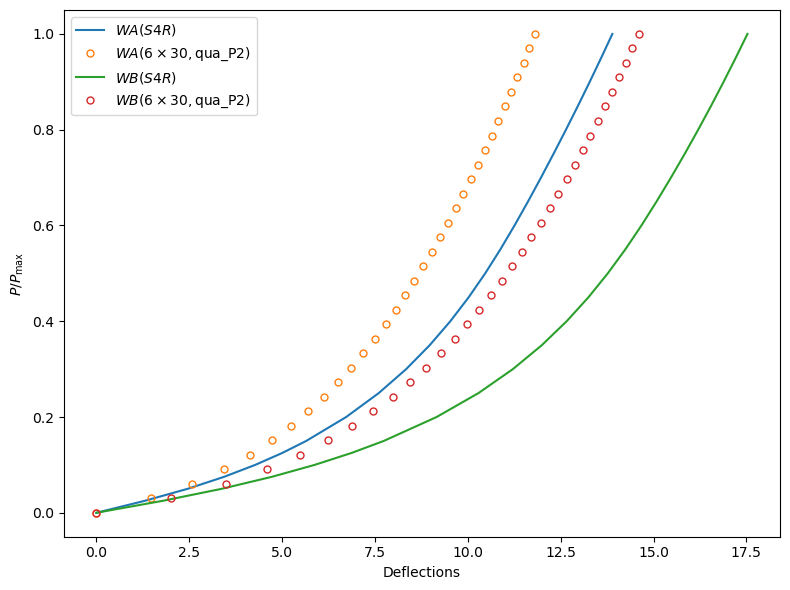

In [16]:
import matplotlib.pyplot as plt

if mesh.comm.rank == 0:
    P_S4R = np.array([0.00, 0.025, 0.050, 0.075, 0.100, 0.125, 0.150, 
                      0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50,
                      0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85,
                      0.90, 0.95, 1.00])
    
    WA_S4R = np.array([0.00, 1.305, 2.455, 3.435, 4.277, 5.007, 5.649, 6.725, 7.602,
                       8.340, 8.974, 9.529, 10.023, 10.468, 10.876, 11.257, 11.620,
                       11.970, 12.310, 12.642, 12.966, 13.282, 13.590, 13.891])
    
    WB_S4R = np.array([0.00, 1.789, 3.370, 4.720, 5.876, 6.872, 7.736, 9.160, 10.288,
                       11.213, 11.992, 12.661, 13.247, 13.768, 14.240, 14.674, 15.081,
                       15.469, 15.842, 16.202, 16.550, 16.886, 17.212, 17.528])
    
    np.savetxt(results_folder/"WA.txt", WA_list)
    np.savetxt(results_folder/"WB.txt", WB_list)
    np.savetxt(results_folder/"Ps_Pmax.txt", Ps/P_max)
    
    fig = plt.figure(figsize=(8.0, 6.0))
    plt.plot(WA_S4R, P_S4R, "-", label="$WA(S4R)$")
    plt.plot(WA_list, Ps/P_max, "o", markersize=5, markerfacecolor='none',
             markevery = 3, label=f"$WA({nex}\\times{ney},${ele_type})")
    plt.plot(WB_S4R, P_S4R, "-", label="$WB(S4R)$")
    plt.plot(WB_list, Ps/P_max, "o", markersize=5, markerfacecolor='none',
             markevery = 3, label=f"$WB({nex}\\times{ney},${ele_type})")
    plt.ylabel(r"$P/P_{\mathrm{max}}$")
    plt.xlabel("Deflections")
    plt.legend()
    plt.tight_layout()
    plt.savefig(results_folder/"comparisons.png", dpi=300)